In [78]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from shapely.geometry import Point
import matplotlib.pyplot as plt
import imageio
import os

In [79]:
hurto = pd.read_csv('hurto/hurto_a_persona_medata.csv',
                encoding='latin-1',
                sep=';',
                decimal=","
                )

hurto = hurto[hurto.lugar == 'Hotel, motel y hostal'].reset_index(drop=True)

In [80]:
# Cargar datos de barrios desde shapefile
barrios = gpd.read_file('barrio/limite_barrio_vereda_cata.shp')

In [6]:
# Convertir la columna 'fecha_hecho' a tipo datetime
hurto['fecha_hecho'] = pd.to_datetime(hurto['fecha_hecho'])

# Convertir latitud y longitud a geometrías de puntos
hurto['geometry'] = hurto.apply(lambda row: Point(row['longitud'], row['latitud']), axis=1)
hurto = gpd.GeoDataFrame(hurto, geometry='geometry')

# Asegurarse de que ambos conjuntos de datos usen el mismo sistema de referencia de coordenadas (CRS)
barrios = barrios.to_crs(epsg=4326)
hurto = hurto.set_crs(epsg=4326)

# Realizar una unión espacial para encontrar delitos dentro de los barrios
hurto_en_barrios = gpd.sjoin(barrios, hurto, how='inner', predicate='intersects')

# Extraer el año de 'fecha_hecho'
hurto_en_barrios['year'] = hurto_en_barrios['fecha_hecho'].dt.year

# Agrupar por año, barrio (usando el campo 'codigo') y modalidad para contar el número de delitos
conteo_hurtos = hurto_en_barrios.groupby(['year', 'codigo','geometry']).size().rename('count').reset_index()

## Gift evolución de hurto en alojamientos

In [72]:
conteo_hurtos = gpd.GeoDataFrame(conteo_hurtos, geometry='geometry') 

vmin = conteo_hurtos['count'].min()
vmax = conteo_hurtos['count'].max()

years = conteo_hurtos['year'].unique()

years = sorted(conteo_hurtos['year'].unique())

# Crear un directorio para guardar las imágenes
os.makedirs('frames', exist_ok=True)

# Generar un mapa para cada año y guardar como imagen
for year in years:
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    barrios.plot(ax=ax,color='#fff5f0', edgecolor='black', label='Comunas')
    conteo_hurtos[conteo_hurtos['year'] == year].plot(ax=ax, column='count', 
                                                        edgecolor='black',
                                                        cmap='Reds', 
                                                        #legend=True, 
                                                        label='Comunas Peligrosas',
                                                        vmin=vmin, 
                                                        vmax=vmax)
    ax.set_xticks([])  # Eliminar números del eje x
    ax.set_yticks([])
    
    plt.title(f'Thefts in hotels, motels, and hostels {year}')
    plt.savefig(f'frames/hurtos_{year}.png')
    plt.close()

In [73]:
# Crear un GIF a partir de las imágenes guardadas
images = []
for year in years:
    images.append(imageio.imread(f'frames/hurtos_{year}.png'))
imageio.mimsave('hurtos_animacion.gif', images, format='GIF', fps=2,loop=0)

/tmp/ipykernel_10534/1504501914.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'frames/hurtos_{year}.png'))


## Nube de variación modalidad de robo

In [75]:
modalidad_ingles = {
  "Atraco": "Robbery",
  "Descuido": "Carelessness",
  "Escopolamina": "Scopolamine",
  "Rompimiento cerradura": "Lock breaking",
  "Raponazo": "Snatch",
  "Engaño": "Deception",
  "Halado": "Pulled",
  "Sin dato": "No data",
  "Cosquilleo": "Tickling",
  "Rompimiento de ventana": "Window breaking",
  "Suplantación": "Impersonation",
  "Llave maestra": "Master key",
    "Clonación de tarjeta":"Card cloning"
}

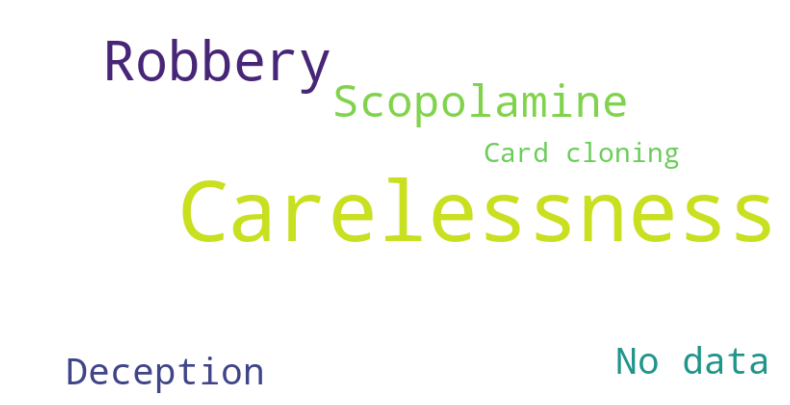

In [76]:
modalidad_hurto_2010=hurto_en_barrios.query('year == 2010').modalidad.value_counts().reset_index().replace(modalidad_ingles).set_index('index').to_dict()['modalidad']

# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(modalidad_hurto_2010)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
#plt.show()
plt.savefig('nube_de_palabras_2010.png')

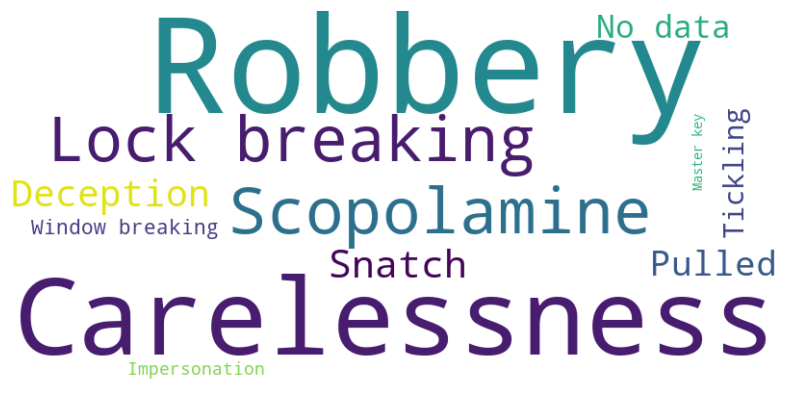

In [68]:
modalidad_hurto_2022=hurto_en_barrios.query('year == 2022').modalidad.value_counts().reset_index().replace(modalidad_ingles).set_index('index').to_dict()['modalidad']

# Generar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(modalidad_hurto_2022)

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
#plt.show()
plt.savefig('nube_de_palabras_2022.png')

## Serie de hurto 

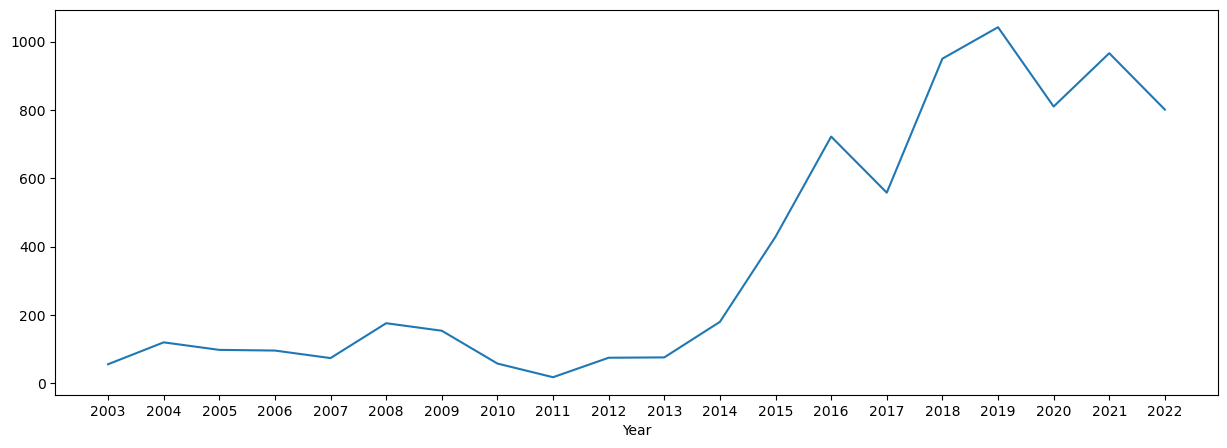

In [70]:
ax = conteo_hurtos.groupby('year')['count'].sum().plot(xticks=list(range(2003,2023)), figsize=(15,5), xlabel='Year')
fig = ax.get_figure()
fig.savefig('grafico_serie_hurtos.png')